# Introduction

The purpose of this notebook is to demonstrate skills relating to machine learning that I have acquired so far. For this I used malaria dataset, which has ~27 000 pictures of red blood cells with or without infection of Plasmodium sp. (causal agent of malaria). You can find out more: https://lhncbc.nlm.nih.gov/publication/pub9932

This notebook has the following sections:
- loading the dataset, data transformation, image visualisation;
- implementation of logistic regression from scratch;
- implementation of logistic regression using scikit learn;
- implementation of deep neural network from scratch;
- implementation of deep neural network using tensorflow.

## Loading the dataset

In [1]:
# Making the necessary imports that will be used troughout this notebook
import numpy as np
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
import os
import PIL
import math

In [2]:
# Loading the dataset
data_dir = "malaria/cell_images"
data_dir = os.path.join(os.getcwd(), data_dir)

In [3]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir, labels='inferred', label_mode='binary', batch_size=32)

Found 27558 files belonging to 2 classes.


Since the dataset is split between to folders, one for healthy and the other for infected cells, then I will load images of healthy and infected cells separately into two lists. After that I will turn lists into numpy arrays, visualise the data, create train, dev and test sets. 

In [4]:
IMG_HEIGHT = 64
IMG_WIDTH = 64
target_size = (IMG_HEIGHT, IMG_WIDTH)

infected_img = []
healthy_img = []

for filename in os.listdir(data_dir):
    for file in os.listdir(os.path.join(data_dir, filename)):
        path = os.path.join(data_dir, filename)
        path = os.path.join(path, file)
        
        if path.endswith(".png"):

            # load the image
            img = tf.keras.preprocessing.image.load_img(
                path, target_size = target_size)

            # report details about the image
            # print(type(img))
            # print(img.format)
            # print(img.mode)
            # print(img.size)

            # show the image
            # img.show()

            # convert to numpy array
            img_array = tf.keras.preprocessing.image.img_to_array(img)
            # print(img_array.dtype)
            # print(img_array.shape)

            # convert numpy array back to image
            # img_pil = tf.keras.preprocessing.image.array_to_img(img_array)
            # print(type(img_pil))

            # show the image
            # plt.imshow(img_array.astype(np.uint8))

            if filename == "Parasitized":
                infected_img.append(img_array)
            else:
                healthy_img.append(img_array)
        else:
            continue

In [5]:
# Turn list of arrays into one array. 
images_healthy = np.stack(healthy_img, axis = 0)
labels_healthy = np.zeros((1, images_healthy.shape[0]))
images_infected = np.stack(infected_img, axis = 0)
labels_infected = np.ones((1, images_infected.shape[0]))

In [6]:
# Sanity check
print("Shape of healthy image array: " + str(images_healthy.shape))
print("Shape of healthy label array: " + str(labels_healthy.shape))
print("Shape of infected image array: " + str(images_infected.shape))
print("Shape of infected label array: " + str(labels_healthy.shape))
print("Shape of an image: " + str(images_healthy[0].shape))

Shape of healthy image array: (13779, 64, 64, 3)
Shape of healthy label array: (1, 13779)
Shape of infected image array: (13779, 64, 64, 3)
Shape of infected label array: (1, 13779)
Shape of an image: (64, 64, 3)


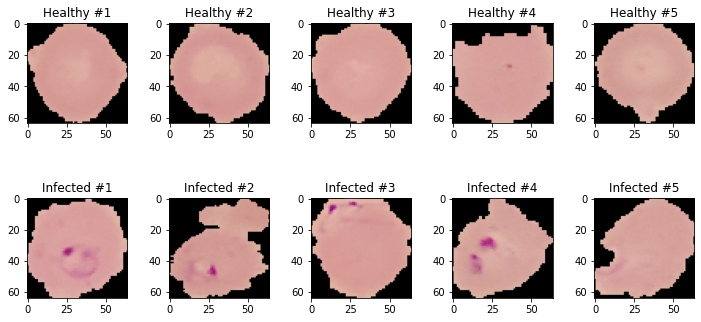

In [39]:
# Visualise the data. You can "scroll" trough the dataset by changing 'index' and then running the cell. 
rows = 2
columns = 5
index = 0
f, axs = plt.subplots(rows, columns, figsize=(10, 5))
f.tight_layout()
for i in range(columns):
    axs[0, i].imshow(healthy_img[index+i].astype(np.uint8))
    axs[0, i].set_title("Healthy #"+str(i+1 + index))
for i in range(columns):
    axs[1, i].imshow(infected_img[index+i].astype(np.uint8))
    axs[1, i].set_title("Infected #"+str(i+1 + index))

In [8]:
# Flatten each image into array of (IMG_HEIGHT * IMG_WIDTH * channel, m), where `m` is number of examples. 
def flatten(image_array):
    '''
    Transforms array of images with shape of [m, IMG_HEIGHT, IMG_WIDTH, 3] 
    into array with shape of [IMG_HEIGHT * IMG_WIDTH * 3, m], where `m` denotes the number of examples. 
    
    Input:
    image_array - numpy array with shape of [m, IMG_HEIGHT, IMG_WIDTH, 3]
    
    Output:
    flat_img_array - numpy array with shape of [IMG_HEIGHT * IMG_WIDTH * 3, m]
    '''
    flat_img_array = np.reshape(image_array, (IMG_HEIGHT * IMG_WIDTH * image_array.shape[-1], -1))
    return flat_img_array

In [9]:
# Flatten the images
images_healthy_flat = flatten(images_healthy)
images_infected_flat = flatten(images_infected)

# Standardize the data to have value between 0...1
images_healthy_flat /= 255.
images_infected_flat /= 255.

In [10]:
# Sanity check
print("Shape of healthy image array: " + str(images_healthy_flat.shape))
print("Shape of healthy images labels: " + str(labels_healthy.shape))
print("Shape of infected image array: " + str(images_infected_flat.shape))
print("Shape of infected images labels: " + str(labels_infected.shape))

Shape of healthy image array: (12288, 13779)
Shape of healthy images labels: (1, 13779)
Shape of infected image array: (12288, 13779)
Shape of infected images labels: (1, 13779)


In [11]:
# Shuffle healthy image and infected image array + labels (shuffling labels for training purposes only). 
# Divide them into training, dev and test set. 
from sklearn.utils import shuffle
ind1 = shuffle(np.arange(images_healthy_flat.shape[1]))
images_healthy_shuffled = images_healthy_flat[:, ind1]
labels_healthy_shuffled = labels_healthy[:, ind1]

ind2 = shuffle(np.arange(images_infected_flat.shape[1]))
images_infected_shuffled = images_infected_flat[:, ind2]
labels_infected_shuffled = labels_infected[:, ind2]

In [12]:
# Sanity check
print("Shape of healthy image array: " + str(images_healthy_flat.shape))
print("Shape of healthy images labels: " + str(labels_healthy.shape))
print("Shape of infected image array: " + str(images_infected_flat.shape))
print("Shape of infected images labels: " + str(labels_infected.shape))

index = 100
print(np.array_equal(images_healthy_flat[index], images_healthy_shuffled[index]))   # must be False
print(np.array_equal(images_infected_flat[index], images_infected_shuffled[index])) # must be False
print(np.array_equal(images_healthy_flat[index], images_healthy_flat[index]))       # must be True

Shape of healthy image array: (12288, 13779)
Shape of healthy images labels: (1, 13779)
Shape of infected image array: (12288, 13779)
Shape of infected images labels: (1, 13779)
False
False
True


In [13]:
# Create a train, dev and test set. [train / dev/ test]  = [20,002 / 3,778 / 3,778]
X_train_orig = np.concatenate((images_healthy_shuffled[:, : 10001], images_infected_shuffled[:, : 10001]), axis=1)
y_train_orig = np.concatenate((labels_healthy_shuffled[:, : 10001], labels_infected_shuffled[:, : 10001]), axis=1)

X_dev_orig = np.concatenate((images_healthy_shuffled[:, 10001 : 11890], images_infected_shuffled[:, 10001 : 11890]), axis=1)
y_dev_orig = np.concatenate((labels_healthy_shuffled[:, 10001 : 11890], labels_infected_shuffled[:, 10001 : 11890]), axis=1)

X_test_orig = np.concatenate((images_healthy_shuffled[:, 11890 : ], images_infected_shuffled[:, 11890 : ]), axis = 1)
y_test_orig = np.concatenate((labels_healthy_shuffled[:, 11890 : ], labels_infected_shuffled[:, 11890 : ]), axis = 1)

In [14]:
# Sanity check
print("Shape of X_train_orig: " + str(X_train_orig.shape))
print("Shape of y_train_orig: " + str(y_train_orig.shape))
print("Shape of X_dev_orig: " + str(X_dev_orig.shape))
print("Shape of y_dev_orig: " + str(y_dev_orig.shape))
print("Shape of X_test_orig: " + str(X_dev_orig.shape))
print("Shape of y_test_orig: " + str(y_test_orig.shape))

Shape of X_train_orig: (12288, 20002)
Shape of y_train_orig: (1, 20002)
Shape of X_dev_orig: (12288, 3778)
Shape of y_dev_orig: (1, 3778)
Shape of X_test_orig: (12288, 3778)
Shape of y_test_orig: (1, 3778)


In [15]:
# Shuffle training, dev and test set. 
ind1 = shuffle(np.arange(X_train_orig.shape[1]))
X_train = X_train_orig[:, ind1]
y_train = y_train_orig[:, ind1]

ind2 = shuffle(np.arange(X_dev_orig.shape[1]))
X_dev = X_dev_orig[:, ind2]
y_dev = y_dev_orig[:, ind2]

ind3 = shuffle(np.arange(X_test_orig.shape[1]))
X_test = X_test_orig[:, ind3]
y_test = y_test_orig[:, ind3]

In [16]:
# Sanity check
print("Shape of X_train: " + str(X_train.shape))
print("Shape of y_train: " + str(y_train.shape))
print("Shape of X_dev: " + str(X_dev.shape))
print("Shape of y_dev: " + str(y_dev.shape))
print("Shape of X_test: " + str(X_dev.shape))
print("Shape of y_test: " + str(y_test.shape))

Shape of X_train: (12288, 20002)
Shape of y_train: (1, 20002)
Shape of X_dev: (12288, 3778)
Shape of y_dev: (1, 3778)
Shape of X_test: (12288, 3778)
Shape of y_test: (1, 3778)


## Logistic regression from scratch

Lets start with simple logistic regression model that will have one input layer and one output layer. Size of the input layer is equal to IMG_HEIGHT * IMG_WIDTH * 3. Output layer consists of one one 'neuron'. In the output layer will be calculated the probability of the image being infected red blood cell. In the output layer we will perform the following calculations: 

Z = w*X+b, where 'x' denotes matrix multiplication, `w` - weights, `X` - training example, `b` - bias. 

A = g(Z), where g(Z) = 1 / (1 + np.exp(-Z))

In [128]:
def initialize_parameters(n_x, n_y):
    '''
    Initialize the parameters `w` and `b` for the logistic regression model. 
    
    Input:
    n_x - number of features.
    n_y - equal to one
    
    Output:
    `w` - numpy array of shape (n_x, 1)
    `b` - array of zeros of shape (1, 1)
    '''
    w = np.random.randn(n_x, n_y) * np.sqrt(2/n_x)
    b = np.zeros((1, n_y))
    return w, b

In [17]:
def sigmoid(x):
    '''
    Perfoms sigmoid function
    
    Input:
    x - can be array, integer, float etc.
    
    Output:
    s - sigmoid function of x
    '''
    s = 1 / (1 + np.exp(-x))
    return s

In [130]:
def forward_propagation(X, w, b):
    '''
    Performs forward propagation
    
    Input:
    X - numpy array 
    w - weights
    b - bias
    
    Output:
    a - product of forward propagation
    '''
    z = np.dot(w.T, X) + b
    a = sigmoid(z)
    
    return a

In [131]:
def cost_calculation(A, Y):
    '''
    Calculate cost using binary cross-entropy/log loss. 
    
    Input:
    `A` - product of forward pass (prediction made by logistic regression)
    `Y` - actual value
    '''
    m = Y.shape[1]
    J = (-1 / m) * (np.dot(Y, np.log(A.T)) + np.dot((1-Y), np.log(1-A.T)))
    return J

In [132]:
def backward_propagation(X, Y, A):
    '''
    Performs backward propagation.
    
    Input:
    X - training sample
    Y - actual value 
    A - product of forward pass (prediction made by logistic regression)
    
    Output:
    dw, db - gradient with respect to parameters 
    
    '''
    m = X.shape[1]    # Number of examples
    dw = (1/m) * np.dot(X, (A-Y).T)
    db = (1/m) * np.sum(A-Y)
    return dw, db

In [133]:
def update_parameters(w, b, dw, db, learning_rate):
    '''
    Updates parameters using values from backward propagation.
    
    Output:
    w, b - updated parameters 
    '''
    w = w - learning_rate * dw
    b = b - learning_rate * db
    return w, b

In [135]:
def predict(X, w, b):
    '''
    Makes prediction give weights, weight and bias.
    
    Output:
    y_predict - numpy array of shape (1, m), where m is the number of examples.
    '''
    m = X.shape[1]
    y_predict = np.zeros((1, m))
    a = forward_propagation(X, w, b)
    np.place(y_predict, a>=0.5, 1)
    return y_predict

In [137]:
def model(X_train, y_train, X_dev, y_dev, learning_rate = 0.001, epochs = 10):
    '''
    Using the functions defined above, train logistic regression model. 
    
    Outputs: 
    Plot containing training loss and validation loss.
    Accuracy on training and validation set.
    Weights and bias of logistic regression model. 
    '''
    
    # Initialize variables
    cost_train = []
    cost_dev = []
    n_x = X_train.shape[0]
    n_y = y_train.shape[0]
    
    # Initialize parameters `w` and `b`.
    w, b = initialize_parameters(n_x, n_y)
    
    for i in range(epochs):

        # Perform forward propagation
        a_train = forward_propagation(X_train, w, b)
        a_dev = forward_propagation(X_dev, w, b)

        # Calculate cost
        J_train  = cost_calculation(a_train, y_train)
        cost_train.append(J_train[0][0])
        J_dev = cost_calculation(a_dev, y_dev)
        cost_dev.append(J_dev[0][0])
        
        # Perform backward propagation
        dw, db = backward_propagation(X_train, y_train, a_train)

        # Update parameters `w` and `b`. 
        w, b = update_parameters(w, b, dw, db, learning_rate)
        
        # Print cost at 1st and every 5th iteration. 
        if (i + 1) % 5 == 0 or i == 0:
            print("Cost after iteration {}: {:.3f}".format(i + 1, cost_train[-1]))
            
        # Report that the model has finished. 
        if i == epochs-1:
            print("Finished training.", end='\n')
    
    # Visualise the cost function 
    plt.plot(list(range(1,len(cost_train)+1)), cost_train, label='Training cost')
    plt.plot(list(range(1, len(cost_dev)+1)), cost_dev, label="Dev cost")
    plt.legend()

    # Accuracy on the training set. 
    y_train_predict = predict(X_train, w, b)
    print("Accuracy on the training set: {:.2f}%".format(100 - np.mean(np.abs(y_train_predict - y_train)) * 100))
    
    # Accuracy on dev set. 
    y_dev_predict = predict(X_dev, w, b)
    print("Accuracy on the dev set: {:.2f}%".format(100 - np.mean(np.abs(y_dev_predict - y_dev)) * 100))
    
    return w, b

Cost after iteration 1: 0.712
Cost after iteration 5: 0.694
Cost after iteration 10: 0.681
Cost after iteration 15: 0.669
Cost after iteration 20: 0.657
Cost after iteration 25: 0.646
Cost after iteration 30: 0.635
Cost after iteration 35: 0.624
Cost after iteration 40: 0.614
Cost after iteration 45: 0.604
Cost after iteration 50: 0.594
Finished training.
Accuracy on the training set: 78.29%
Accuracy on the dev set: 78.19%


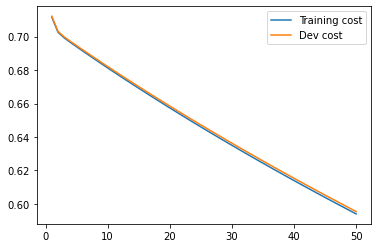

In [138]:
# Train the model.
w, b = model(X_train, y_train, X_dev, y_dev, epochs=50)

In [139]:
# Accracy on the test set. 
pred = predict(X_test, w, b)
print("Test set accuracy: {:.2f}%".format(100-np.mean(np.abs(pred - y_test)) * 100))

Test set accuracy: 77.47%


Simple logistic regression model gave us accuracy of 77%, which is quite good. Let's check the validity of our result by implementing logistic regression model using sci kit learn. 

## Implement logistic regression using scikit learn

In [140]:
# Fit the logistic regression model
from sklearn.linear_model import LogisticRegression
clf = LogisticRegression(random_state=0, max_iter=50)
model = clf.fit(X_train.T, np.ravel(y_train.T))

C:\Users\nkta1\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


In [141]:
# Calculate accuracy on train, dev and test sets.
acc_train = model.score(X_train.T, y_train.T)
acc_dev = model.score(X_dev.T, y_dev.T)
acc_test = model.score(X_test.T, y_test.T)

In [142]:
print("Train set accuracy: "+ str(acc_train * 100) + "%")
print("Dev set accuracy: " + str(acc_dev * 100) + "%")
print("Test set accuracy: " + str(acc_test * 100) + "%")

Train set accuracy: 100.0%
Dev set accuracy: 100.0%
Test set accuracy: 100.0%


I am not sure what to think of this accuracy of 100%... There must be some kind of mistake that I did in those few lines of code, but anyways. Let's just move on, because we have baseline accuracy of 77% that we got on our own implementation of logistic regression. Let's beat that with some neural nets.

## Deep neural network from scratch.
Heading to the most challenging part of the notebook, which is coding my own neural network. 

In [32]:
def initialize_parameters_deep(layer_dims):
    '''
    Initialize deep neural network parameters w1, b1 to w[L], b[L], 
    where L stands for the number of layers in the neural net.
    
    w[l].shape = (neurons in the current layer, neurons in the previous layer)
    b[l].shape = (neurons in the current layer, 1)
    
    Output: parameters
    '''
    L = len(layer_dims)
    parameters = {}
    for i in range(1, L):
        parameters["W" + str(i)] = np.random.randn(layer_dims[i], layer_dims[i-1]) * np.sqrt(2/layer_dims[i-1])
        parameters["b" + str(i)] = np.zeros((layer_dims[i], 1)) 
    
    return parameters

In [19]:
def create_mini_batches(X, y, batch_size = 1, seed = 0):
    '''
    Takes as input X and y, returns mini-batches of size batch_size. If the last batch is smaller than batch_size,
    then add it as it is. 
    '''
    # Number of full mini-batches
    full_batches = int(X.shape[1] / batch_size)
    X_batch = []
    y_batch = []
    
    # Reshuffle `X` and `y`
    ind = shuffle(np.arange(X.shape[1]), random_state = seed)
    X_reshuffled = X[:, ind]
    y_reshuffled = y[:, ind]
    
    # Generate mini-batches that are in length batch_size
    for i in range(full_batches):
        X_minibatch = X_reshuffled[:, i * batch_size : batch_size * (i + 1)]
        y_minibatch = y_reshuffled[:, i * batch_size : batch_size * (i + 1)]
        
        X_batch.append(X_minibatch)
        y_batch.append(y_minibatch)
        
    # Generate incomplete batches     
    if X.shape[1] % batch_size != 0:
        incomplete_X_batch = X_reshuffled[:, full_batches * batch_size : ]
        X_batch.append(incomplete_X_batch)
        incomplete_y_batch = y_reshuffled[:, full_batches * batch_size : ]
        y_batch.append(incomplete_y_batch)
    
    assert len(X_batch) == math.ceil(X.shape[1] / batch_size)
    assert X_batch[0].shape == (X.shape[0], batch_size)
    assert y_batch[0].shape == (1, batch_size)
    
    return X_batch, y_batch

In [20]:
def linear_forward_propagation(X, w, b):
    '''
    Perform linear part of the forward propagation.
    '''
    Z = np.dot(w, X) + b
    
    assert Z.shape == (w.shape[0], X.shape[1])
    
    return Z

In [21]:
def relu(Z):
    '''
    Calculates ReLU activation function, which will be used as activation function for the hidden layers. 
    '''
    
    Z_relu = np.maximum(0, Z)
    
    assert Z_relu.shape == Z.shape
    
    return Z_relu

In [22]:
def forward_propagation_deep(X, parameters):
    '''
    Perform forward propagation for the deep neural network.
    
    Arguments:
    X - data that the forward propagation is performed on
    parameters - dictionary of parameters W[1], b[1] to W[L], b[L], where [L] marks the last layer of the neural net.
    
    Returns:
    AL -  Activation value of the last layer. 
    cache - dictionary containing values A[1], Z[1] to A[L], Z[L], where[L] marks the last layer of the neural net.
    
    '''
    # Number of layers in neural network
    L = len(parameters) // 2
    
    cache = {}
    A = X
    cache["A0"] = A
    
    # Perform ReLU activation function for hidden layers. 
    for i in range(1, L):
        A_prev = A
        Z = linear_forward_propagation(A_prev, parameters["W" + str(i)], parameters["b" + str(i)])
        A = relu(Z)
        
        cache["A" + str(i)] = A
        cache["Z" + str(i)] = Z

        
    # Perform sigmoid activation function for last layer of the network. 
    A_prev = A
    Z = linear_forward_propagation(A_prev, parameters["W" + str(L)], parameters["b" + str(L)])
    AL = sigmoid(Z)
    
    cache["A" + str(L)] = AL
    cache["Z" + str(L)] = Z

               
    return AL, cache   

In [23]:
def cost_calculate_deep(A, Y):
    '''
    Calculate binary cross-entropy/log loss. 
    '''
    m = Y.shape[1]
    logprobs = np.dot(Y,np.log(A.T)) + np.dot((1-Y),np.log(1-A).T)
    cost = -1/m * logprobs
    
    return cost[0][0]

In [24]:
# relu_backward and sigmoid_backward are not coded me. 
# This code was copied from notebook "Building your Deep Neural Network: Step by Step", 
# which I got access to from "Neural Network and Deep learning" course on www.coursera.org. 
def relu_backward(dA, cache):
    """
    Implement the backward propagation for a single ReLU unit.

    Arguments:
    dA -- post-activation gradient, of any shape
    cache -- 'Z' where we store for computing backward propagation efficiently

    Returns:
    dZ -- Gradient of the cost with respect to Z
    """
    
    Z = cache
    dZ = np.array(dA, copy=True) # just converting dz to a correct object.
    
    # When z <= 0, you should set dz to 0 as well. 
    dZ[Z <= 0] = 0
    
    assert (dZ.shape == Z.shape)
    
    return dZ

def sigmoid_backward(dA, cache):
    """
    Implement the backward propagation for a single SIGMOID unit.

    Arguments:
    dA -- post-activation gradient, of any shape
    cache -- 'Z' where we store for computing backward propagation efficiently

    Returns:
    dZ -- Gradient of the cost with respect to Z
    """
    
    Z = cache
    
    s = 1/(1+np.exp(-Z))
    dZ = dA * s * (1-s)
    
    assert (dZ.shape == Z.shape)
    
    return dZ


In [25]:
def linear_backward(dZ, A_prev, W):
    '''
    Perform linear part of the backward propagation.
    '''
    # Number of samples
    m = A_prev.shape[1]
    
    # Perform linear gradient calculations
    
    dW = 1/m * np.dot(dZ, A_prev.T)
    db = 1/m * np.sum(dZ, axis=1, keepdims=True)
    dA_prev = np.dot(W.T, dZ)

    assert dA_prev.shape == (W.shape[1], m)
    
    return dA_prev, dW, db

In [26]:
def linear_activation_backward(dA, Z, W, A_prev, activation):
    '''
    Performs backward propagation for the layer. Takes into account if the layer had sigmoid or ReLU activation functions.
    '''
    if activation == 'sigmoid':
        dZ = sigmoid_backward(dA, Z)
        dA_prev, dW, db = linear_backward(dZ, A_prev, W)
        
    if activation == 'relu':
        dZ = relu_backward(dA, Z)
        dA_prev, dW, db = linear_backward(dZ, A_prev, W)
        
    return dA_prev, dW, db


In [27]:
def backward_propagation_deep(AL, Y, parameters, cache):
    '''
    Performs complete backward propagation over all layers. 
    '''
    L = len(parameters) // 2
    m = Y.shape[1]
    grads = {}
    Y = Y.reshape(AL.shape)
    
    # Initialize backward propagation
    dAL = -(np.divide(Y, AL) - np.divide(1-Y, 1-AL))
    
    # Lth layer gradient
    grads["dA" + str(L-1)], grads["dW" + str(L)], grads["db" + str(L)] = linear_activation_backward(dA=dAL, Z=cache["Z"+str(L)], W=parameters["W" + str(L)], A_prev = cache["A"+str(L-1)], activation='sigmoid')
    
    
    # Loop over hidden units
    for i in reversed(range(L-1)):
        dA_prev, dW, db = linear_activation_backward(grads["dA"+str(i+1)], cache["Z"+str(i+1)], parameters["W"+str(i+1)], cache["A" + str(i)], activation='relu')
        grads["dA" + str(i)] = dA_prev
        grads["dW" + str(i+1)] = dW
        grads["db" + str(i+1)] = db
        
        
    assert grads["dW" + str(i+1)].shape == parameters["W"+str(i+1)].shape
        
    return grads

In [28]:
def update_parameters_deep(parameters, grads, learning_rate):
    '''
    Updates parameters based on learning rate and gradients calculated by performing backward propagation. 
    '''
    L = len(parameters) // 2
    for i in range(1, L+1):
        parameters["W" + str(i)] = parameters["W" + str(i)] - learning_rate * grads["dW" + str(i)]
        parameters["b" + str(i)] = parameters["b" + str(i)] - learning_rate * grads["db" + str(i)]
    return parameters

In [29]:
def predict_deep(X, Y, parameters):
    '''
    Makes prediction on X. 
    '''
    preds = np.zeros((Y.shape))
    a, _ = forward_propagation_deep(X, parameters)
    np.place(preds, a>=0.5, 1)
    return preds

In [30]:
def NN_model(X, y, layer_dims, learning_rate = 0.0075, nr_iter = 50, seed = 0, batch_size = 1):
    '''
    Creates deep neural network. Neural network can be built using layer_dims. For example layer_dims = [n_x, 32, 1] is
    neural network with n_x neurons in input layer, 32 neurons in hidden layer, 1 neuron in output layer. 
    `Seed` is used in order to create different mini-batches. 
    '''
    m = X.shape[1]
    costs = []
    # Initilialize parameters
    parameters = initialize_parameters_deep(layer_dims)
    
    # Iterate over dataset i times
    for i in range(0, nr_iter):
        
        seed += 1
        X_batch, y_batch = create_mini_batches(X, y, batch_size = batch_size, seed = seed)
        cost = 0
        
        # Iterate over mini_batch
        for k in range(len(X_batch)):
            
            # Perform forward propagation
            AL, cache = forward_propagation_deep(X_batch[k], parameters)
                  
            # Calculate cost function
            cost += cost_calculate_deep(AL, y_batch[k])
            
            # Perform backward propagation
            grads = backward_propagation_deep(AL, y_batch[k], parameters, cache)
            
            # Update parameters
            parameters = update_parameters_deep(parameters, grads, learning_rate)
            
        avg_cost = cost/len(X_batch)
        costs.append(avg_cost)
        
        print("Cost on iteration {}: {:.4f}".format(i+1, avg_cost))
            
    
    d = {
        "cost": costs,
        "parameters": parameters
        }
    print("Finished.")
    
    return d

In [103]:
# Train neural net.
n_x = X_train.shape[0]
layer_dims = [n_x, 16, 1]

d = NN_model(X_train, y_train, layer_dims, batch_size=1024, learning_rate=0.0075, nr_iter = 20)

Cost on iteration 1: 0.6928
Cost on iteration 2: 0.6924
Cost on iteration 3: 0.6917
Cost on iteration 4: 0.6908
Cost on iteration 5: 0.6895
Cost on iteration 6: 0.6876
Cost on iteration 7: 0.6850
Cost on iteration 8: 0.6806
Cost on iteration 9: 0.6742
Cost on iteration 10: 0.6641
Cost on iteration 11: 0.6490
Cost on iteration 12: 0.6266
Cost on iteration 13: 0.5943
Cost on iteration 14: 0.5503
Cost on iteration 15: 0.4943
Cost on iteration 16: 0.4288
Cost on iteration 17: 0.3597
Cost on iteration 18: 0.2942
Cost on iteration 19: 0.2366
Cost on iteration 20: 0.1904
Finished.


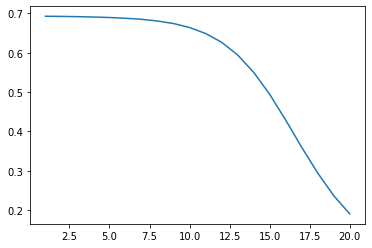

In [104]:
# Visualise the cost function while training the neural net. 
plt.plot(list(range(1, len(d["cost"]) + 1)), d['cost'])

In [33]:
# Accuracy on training set. 
preds_train = predict_deep(X_train, y_train, d["parameters"])
print("Accuracy on train set: " + str(100 - np.mean(np.abs(preds_train-y_train)) * 100))

Accuracy on train set: 100.0


In [34]:
# Accuracy on dev set. 
preds_dev = predict_deep(X_dev, y_dev, d["parameters"])
print("Accuracy on dev set: " + str(100 - np.mean(np.abs(preds_dev-y_dev)) * 100))

Accuracy on dev set: 100.0


In [35]:
# Accuracy on test set. 
preds_test = predict_deep(X_test, y_test, d["parameters"])
print("Accuracy on test set: " + str(100 - np.mean(np.abs(preds_test-y_test)) * 100))

Accuracy on test set: 100.0


We can increase the size of our hidden layer by adding numbers to `layer_dims`. 

In [34]:
# Set structure for neural net. 
n_x = X_train.shape[0]
layer_dims = [n_x, 128, 32, 1]

d = NN_model(X_dev, y_dev, layer_dims, batch_size=64, learning_rate=0.0075, nr_iter = 20)

Cost on iteration 1: 0.6016
Cost on iteration 2: 0.3925
Cost on iteration 3: 0.1779
Cost on iteration 4: 0.1540
Cost on iteration 5: 0.0290
Cost on iteration 6: 0.0186
Cost on iteration 7: 0.0134
Cost on iteration 8: 0.0102
Cost on iteration 9: 0.0083
Cost on iteration 10: 0.0068
Cost on iteration 11: 0.0059
Cost on iteration 12: 0.0051
Cost on iteration 13: 0.0044
Cost on iteration 14: 0.0039
Cost on iteration 15: 0.0035
Cost on iteration 16: 0.0032
Cost on iteration 17: 0.0029
Cost on iteration 18: 0.0026
Cost on iteration 19: 0.0024
Cost on iteration 20: 0.0023
Finished.


Interesting note. Before getting results as I do now, I tried initializing weights randomly, but it did not want to converge, so I used He initialization instead. The result is pretty remarkable, because with random initialization cost did not change for 10 iterations.

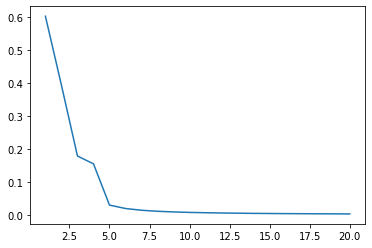

In [35]:
# Visualise the change of the cost during training. 
plt.plot(list(range(1, len(d["cost"]) + 1)), d['cost'])

In [36]:
# Accuracy on training set. 
preds_train = predict_deep(X_train, y_train, d["parameters"])
print("Accuracy on train set: " + str(100 - np.mean(np.abs(preds_train-y_train)) * 100))

Accuracy on train set: 100.0


In [37]:
# Accuracy on dev set. 
preds_dev = predict_deep(X_dev, y_dev, d["parameters"])
print("Accuracy on dev set: " + str(100 - np.mean(np.abs(preds_dev-y_dev)) * 100))

Accuracy on dev set: 100.0


In [38]:
# Accuracy on test set. 
preds_test = predict_deep(X_test, y_test, d["parameters"])
print("Accuracy on test set: " + str(100 - np.mean(np.abs(preds_test-y_test)) * 100))

Accuracy on test set: 100.0


## Neural networks using tensorflow
The previous lines of code was a lot of matrix multiplication, which gave a good intuition about the inner life of neural networks. Everything the same can be achieved by tensorflow in just few lines of code. 

In [52]:
# Build the model
model = keras.Sequential([
    tf.keras.layers.Dense(16, activation='relu', input_shape=(IMG_HEIGHT*IMG_WIDTH*3,)),
    tf.keras.layers.Dense(1, activation="sigmoid")
])

In [53]:
# Set the optimization and loss parameters. 
model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)

In [47]:
# Train the model
history = model.fit(X_train.T, y_train.T, epochs = 20, validation_data=(X_dev.T, y_dev.T), batch_size=1024)

Epoch 1/20
20/20 [==============================] - 2s 79ms/step - loss: 1.0225 - accuracy: 0.5634 - val_loss: 0.6314 - val_accuracy: 0.5011
Epoch 2/20
20/20 [==============================] - 1s 69ms/step - loss: 0.3812 - accuracy: 0.9380 - val_loss: 0.2680 - val_accuracy: 1.0000
Epoch 3/20
20/20 [==============================] - 1s 68ms/step - loss: 0.2141 - accuracy: 1.0000 - val_loss: 0.1603 - val_accuracy: 1.0000
Epoch 4/20
20/20 [==============================] - 1s 67ms/step - loss: 0.1311 - accuracy: 1.0000 - val_loss: 0.1027 - val_accuracy: 1.0000
Epoch 5/20
20/20 [==============================] - 1s 66ms/step - loss: 0.0870 - accuracy: 1.0000 - val_loss: 0.0710 - val_accuracy: 1.0000
Epoch 6/20
20/20 [==============================] - 1s 67ms/step - loss: 0.0619 - accuracy: 1.0000 - val_loss: 0.0525 - val_accuracy: 1.0000
Epoch 7/20
20/20 [==============================] - 1s 69ms/step - loss: 0.0465 - accuracy: 1.0000 - val_loss: 0.0399 - val_accuracy: 1.0000
Epoch 8/20
20

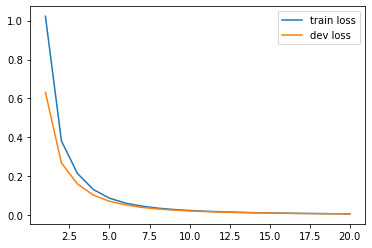

In [48]:
plt.plot(list(range(1, len(history.history['loss'])+1)), history.history['loss'], label='train loss')
plt.plot(list(range(1, len(history.history['val_loss'])+1)), history.history['val_loss'], label='dev loss')
plt.legend()

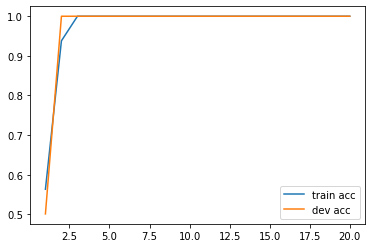

In [49]:
plt.plot(list(range(1, len(history.history['accuracy'])+1)), history.history['accuracy'], label='train acc')
plt.plot(list(range(1, len(history.history['val_accuracy'])+1)), history.history['val_accuracy'], label='dev acc')
plt.legend()

In [50]:
# Accuracy on test set. 
results = model.evaluate(X_test.T, y_test.T, batch_size=128)

print("test loss, test acc:", results)

30/30 [==============================] - 0s 6ms/step - loss: 0.0063 - accuracy: 1.0000
test loss, test acc: [0.006304935086518526, 1.0]


In [74]:
model = keras.Sequential([
    tf.keras.layers.Dense(32, activation ='relu', input_shape=(IMG_HEIGHT*IMG_WIDTH*3,)),
    tf.keras.layers.Dense(4, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

In [75]:
model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy'])

In [76]:
history = model.fit(X_train.T, y_train.T, epochs = 10, validation_data=(X_dev.T, y_dev.T), batch_size=512)

Epoch 1/10
40/40 [==============================] - 2s 42ms/step - loss: 0.3533 - accuracy: 0.8684 - val_loss: 0.0902 - val_accuracy: 1.0000
Epoch 2/10
40/40 [==============================] - 2s 44ms/step - loss: 0.0448 - accuracy: 1.0000 - val_loss: 0.0205 - val_accuracy: 1.0000
Epoch 3/10
40/40 [==============================] - 2s 40ms/step - loss: 0.0144 - accuracy: 1.0000 - val_loss: 0.0096 - val_accuracy: 1.0000
Epoch 4/10
40/40 [==============================] - 2s 40ms/step - loss: 0.0076 - accuracy: 1.0000 - val_loss: 0.0057 - val_accuracy: 1.0000
Epoch 5/10
40/40 [==============================] - 2s 40ms/step - loss: 0.0047 - accuracy: 1.0000 - val_loss: 0.0038 - val_accuracy: 1.0000
Epoch 6/10
40/40 [==============================] - 2s 39ms/step - loss: 0.0032 - accuracy: 1.0000 - val_loss: 0.0027 - val_accuracy: 1.0000
Epoch 7/10
40/40 [==============================] - 2s 41ms/step - loss: 0.0024 - accuracy: 1.0000 - val_loss: 0.0020 - val_accuracy: 1.0000
Epoch 8/10
40

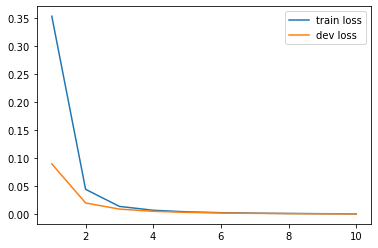

In [77]:
plt.plot(list(range(1, len(history.history['loss'])+1)), history.history['loss'], label='train loss')
plt.plot(list(range(1, len(history.history['val_loss'])+1)), history.history['val_loss'], label='dev loss')
plt.legend()

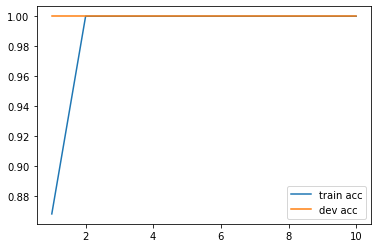

In [78]:
plt.plot(list(range(1, len(history.history['accuracy'])+1)), history.history['accuracy'], label='train acc')
plt.plot(list(range(1, len(history.history['val_accuracy'])+1)), history.history['val_accuracy'], label='dev acc')
plt.legend()

In [79]:
results = model.evaluate(X_test.T, y_test.T)
print("test loss, test acc", results)

119/119 [==============================] - 0s 3ms/step - loss: 0.0010 - accuracy: 1.0000
test loss, test acc [0.0010458396282047033, 1.0]
